In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# --- Parameters ---

# Define the batch size for training
batch_size = 8  # A smaller batch size is chosen due to the small dataset size

# --- Data Generators ---

# Training data generator with data augmentation and validation split
train_data_generator = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,       # Reserve 20% of training data for validation
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training data iterator
train_iterator = train_data_generator.flow_from_directory(
    directory='Covid19-dataset/train',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify subset as training
)

# Validation data iterator
validation_iterator = train_data_generator.flow_from_directory(
    directory='Covid19-dataset/train',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify subset as validation
)

# Test data generator without data augmentation
test_data_generator = ImageDataGenerator(
    rescale=1.0/255  # Only rescale pixel values
)

# Test data iterator
test_iterator = test_data_generator.flow_from_directory(
    directory='Covid19-dataset/test',
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [4]:
# Training class distribution
print("\nTraining class distribution:")
for cls in sorted(train_iterator.class_indices.keys()):
    idx = train_iterator.class_indices[cls]
    count = np.sum(train_iterator.labels == idx)
    print(f"{cls}: {count} samples")

# Validation class distribution
print("\nValidation class distribution:")
for cls in sorted(validation_iterator.class_indices.keys()):
    idx = validation_iterator.class_indices[cls]
    count = np.sum(validation_iterator.labels == idx)
    print(f"{cls}: {count} samples")

# Test class distribution
print("\nTest class distribution:")
for cls in sorted(test_iterator.class_indices.keys()):
    idx = test_iterator.class_indices[cls]
    count = np.sum(test_iterator.classes == idx)
    print(f"{cls}: {count} samples")



Training class distribution:
Covid: 89 samples
Normal: 56 samples
Pneumonia: 56 samples

Validation class distribution:
Covid: 22 samples
Normal: 14 samples
Pneumonia: 14 samples

Test class distribution:
Covid: 26 samples
Normal: 20 samples
Pneumonia: 20 samples


In [5]:
def build_model():
    """
    Builds and compiles a Convolutional Neural Network (CNN) model for multi-class image classification.

    The model is designed to classify grayscale images into three categories.
    """

    # Initialize a sequential model
    model = Sequential()

    # Input layer accepting grayscale images of size 256x256 pixels
    model.add(tf.keras.Input(shape=(256, 256, 1)))

    # --- First Convolutional Block ---
    # Convolutional Layer:
    # - Filters: 5
    # - Kernel Size: 5x5
    # - Strides: 3 (reduces the spatial dimensions)
    # - Activation: ReLU (introduces non-linearity)
    model.add(layers.Conv2D(
        filters=5,
        kernel_size=(5, 5),
        strides=3,
        activation='relu'
    ))
    # Max Pooling Layer:
    # - Pool Size: 2x2
    # - Strides: 2 (further reduces spatial dimensions)
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    ))
    # Dropout Layer:
    # - Rate: 15% (randomly sets inputs to zero during training to prevent overfitting)
    model.add(layers.Dropout(0.15))

    # --- Second Convolutional Block ---
    # Convolutional Layer:
    # - Filters: 3
    # - Kernel Size: 3x3
    # - Strides: 1 (maintains spatial dimensions)
    # - Activation: ReLU
    model.add(layers.Conv2D(
        filters=3,
        kernel_size=(3, 3),
        strides=1,
        activation='relu'
    ))
    # Max Pooling Layer:
    # - Pool Size: 2x2
    # - Strides: 2
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2
    ))
    # Dropout Layer:
    # - Rate: 25%
    model.add(layers.Dropout(0.25))

    # Flatten Layer:
    # - Flattens the output of the convolutional blocks to a 1D vector
    model.add(layers.Flatten())

    # Output Layer:
    # - Dense Layer with Softmax activation for multi-class classification
    # - Units: 3 (one for each class)
    model.add(layers.Dense(
        units=3,
        activation='softmax'
    ))

    # Compile the model with specified optimizer, loss function, and metrics
    print("\nCompiling model...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with learning rate of 0.001
        loss=tf.keras.losses.CategoricalCrossentropy(),            # Loss function for multi-class classification
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(),               # Measures how often predictions match one-hot labels
            tf.keras.metrics.AUC()                                # Computes Area Under the Curve (AUC) metric
        ],
    )

    # Display the model's architecture
    model.summary()

    return model

# Instantiate and build the model
model = build_model()


Compiling model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 84, 84, 5)      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 3)      │           138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871 (15.12 KB)

 Trainable params: 3,871 (15.12 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=5,                  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,   # Restore the weights of the best epoch
    verbose=1
)

# Train the model
history = model.fit(
    train_iterator,
    epochs=25,
    validation_data=validation_iterator,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/25


C:\Users\zhbre\anaconda3\envs\analysis\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.4676 - categorical_accuracy: 0.3039 - loss: 1.5173 - val_auc: 0.7495 - val_categorical_accuracy: 0.6000 - val_loss: 0.9922
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.7760 - categorical_accuracy: 0.5683 - loss: 0.8894 - val_auc: 0.9045 - val_categorical_accuracy: 0.8000 - val_loss: 0.8429
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.8266 - categorical_accuracy: 0.6406 - loss: 0.8128 - val_auc: 0.8776 - val_categorical_accuracy: 0.7200 - val_loss: 0.7302
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - auc: 0.8602 - categorical_accuracy: 0.7091 - loss: 0.7261 - val_auc: 0.9412 - val_categorical_accuracy: 0.8200 - val_loss: 0.5511
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - auc: 0.8512 - categorical_accuracy: 0.6916 - loss: 0.7186 - val_auc: 0.9605 - val_categorical_accuracy: 0.8400 - val_loss: 0.4443
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - auc: 0.9201 - categorical_accuracy: 0.7795 

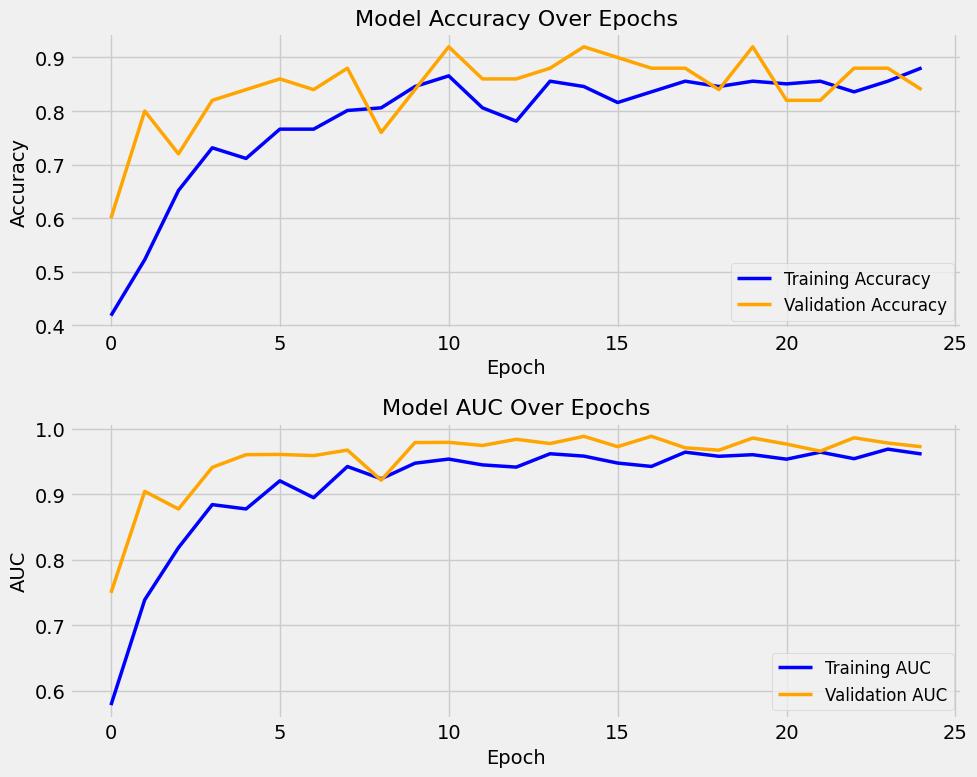

In [7]:
# --- Visualizing Model Performance ---

"""
This code visualizes the training history of the neural network model by plotting:

1. Training and validation accuracy over epochs.
2. Training and validation AUC (Area Under the ROC Curve) over epochs.

It uses Seaborn for enhanced visualization and Matplotlib for plotting.
"""

# Apply Seaborn style for aesthetic plots
plt.style.use("fivethirtyeight")

# Create a figure with two subplots arranged vertically
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# --- Plotting Categorical Accuracy ---

# Plot training accuracy over epochs
sns.lineplot(
    x=range(len(history.history['categorical_accuracy'])),  # Epochs for training data
    y=history.history['categorical_accuracy'],              # Training accuracy values
    ax=axes[0],                                             # Plot on the first subplot
    label='Training Accuracy',                              # Label for the legend
    color='blue',                                           # Line color
    linewidth=2.5                                           # Line width
)

# Plot validation accuracy over epochs
sns.lineplot(
    x=range(len(history.history['val_categorical_accuracy'])),  # Epochs for validation data
    y=history.history['val_categorical_accuracy'],              # Validation accuracy values
    ax=axes[0],                                                 # Plot on the first subplot
    label='Validation Accuracy',                                # Label for the legend
    color='orange',                                             # Line color
    linewidth=2.5                                               # Line width
)

# Customize the first subplot (Accuracy plot)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=16)    # Set the title with font size
axes[0].set_xlabel('Epoch', fontsize=14)                        # Set x-axis label
axes[0].set_ylabel('Accuracy', fontsize=14)                     # Set y-axis label
axes[0].legend(loc='best', fontsize=12)                         # Display the legend
axes[0].grid(True)                                              # Enable grid for better readability

# --- Plotting AUC (Area Under the Curve) ---

# Plot training AUC over epochs
sns.lineplot(
    x=range(len(history.history['auc'])),      # Epochs for training data
    y=history.history['auc'],                  # Training AUC values
    ax=axes[1],                                # Plot on the second subplot
    label='Training AUC',                      # Label for the legend
    color='blue',                              # Line color
    linewidth=2.5                              # Line width
)

# Plot validation AUC over epochs
sns.lineplot(
    x=range(len(history.history['val_auc'])),  # Epochs for validation data
    y=history.history['val_auc'],              # Validation AUC values
    ax=axes[1],                                # Plot on the second subplot
    label='Validation AUC',                    # Label for the legend
    color='orange',                            # Line color
    linewidth=2.5                              # Line width
)

# Customize the second subplot (AUC plot)
axes[1].set_title('Model AUC Over Epochs', fontsize=16)         # Set the title with font size
axes[1].set_xlabel('Epoch', fontsize=14)                        # Set x-axis label
axes[1].set_ylabel('AUC', fontsize=14)                          # Set y-axis label
axes[1].legend(loc='best', fontsize=12)                         # Display the legend
axes[1].grid(True)                                              # Enable grid for better readability

# Adjust the layout to prevent overlap and ensure a clean presentation
plt.tight_layout()
plt.savefig('training_history.png')
# Display the plots
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Classification Report on Validation Data:


,precision,recall,f1-score,support
Covid,0.954545,0.954545,0.954545,22.0
Normal,0.909091,0.714286,0.800000,14.0
Pneumonia,0.823529,1.000000,0.903226,14.0
accuracy,0.900000,0.900000,0.900000,0.9
macro avg,0.895722,0.889610,0.885924,50.0
weighted avg,0.905134,0.900000,0.896903,50.0


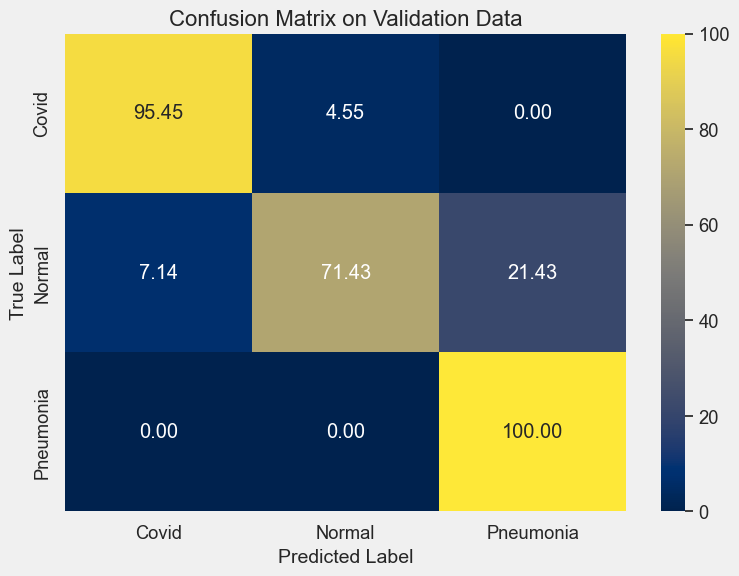

In [8]:
# --- Generating Predictions and Classification Report on Validation Data ---

"""
This code evaluates the model's performance on the validation data, which was used during training to monitor progress.
"""

# Calculate the number of steps for the validation iterator
validation_steps = math.ceil(validation_iterator.samples / validation_iterator.batch_size)

# Generate predictions for the validation data
predictions = model.predict(
    validation_iterator,
    steps=validation_steps
)

# Convert the predicted probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true class labels from the validation iterator
true_classes = validation_iterator.classes

# Get the class label names mapping from the validation iterator
class_labels = list(validation_iterator.class_indices.keys())

# Generate a classification report
report_dict = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Display the classification report
print("\nClassification Report on Validation Data:")
display(report_df)

# Compute the confusion matrix
cm = confusion_matrix(
    true_classes,
    predicted_classes,
    normalize='true'  # Each row will sum to 1 (or 100 after scaling)
) * 100  # Convert to percentages

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(
    cm,
    annot=True,
    fmt='.2f',
    cmap='cividis',
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix on Validation Data', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_auc = model.evaluate(test_iterator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - auc: 0.9175 - categorical_accuracy: 0.8090 - loss: 0.5699

Test Loss: 0.5310
Test Accuracy: 0.8182
Test AUC: 0.9281


C:\Users\zhbre\anaconda3\envs\analysis\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [10]:
# Calculate steps per epoch for the test iterator
test_steps_per_epoch = math.ceil(test_iterator.samples / test_iterator.batch_size)

# Generate predictions for the test data
predictions = model.predict(
    test_iterator,
    steps=test_steps_per_epoch
)

# Convert predicted probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true class labels from the test iterator
true_classes = test_iterator.classes

# Get class label names
class_labels = list(test_iterator.class_indices.keys())

# Generate classification report
report_dict = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels,
    output_dict=True
)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Display the classification report
print("\nClassification Report on Test Data:")
display(report_df)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Classification Report on Test Data:


,precision,recall,f1-score,support
Covid,0.956522,0.846154,0.897959,26.000000
Normal,0.692308,0.900000,0.782609,20.000000
Pneumonia,0.823529,0.700000,0.756757,20.000000
accuracy,0.818182,0.818182,0.818182,0.818182
macro avg,0.824120,0.815385,0.812442,66.000000
weighted avg,0.836156,0.818182,0.820216,66.000000


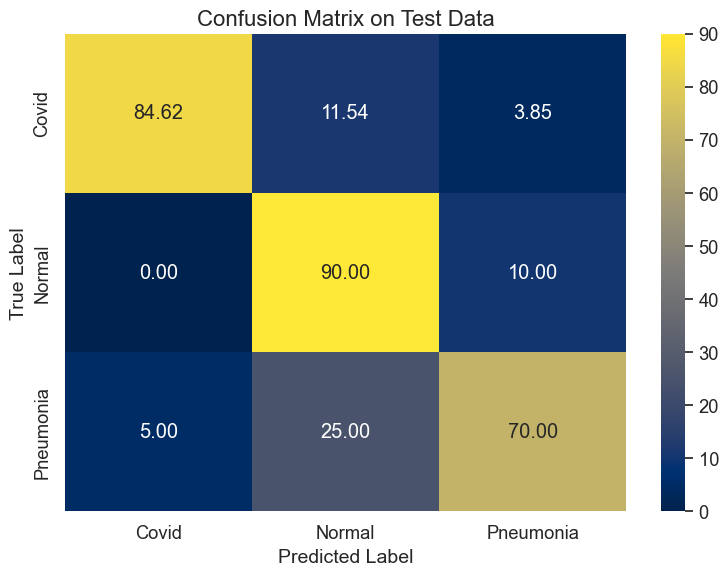

In [11]:
# Compute the confusion matrix for the test data
cm = confusion_matrix(
    true_classes,
    predicted_classes,
    normalize='true'
) * 100  # Convert to percentages

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(
    cm,
    annot=True,
    fmt='.2f',
    cmap='cividis',
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix on Test Data', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.savefig('test_confusion_matrix.png')
plt.show()
